# Imports
- Import libraries
- Import data to df
    - EDA
    - check for NA's
        - NA in rating column, will be dropping
    - check for duplicated
        - No duplicates
- Split dataframe into high_rating(>=9) and low_ratings(<=4)
- NLTK and SpaCy for preprocessing text
    - create nlp object
        - Disable recognizer
    - create several versions of the data
        - lemmatized
        - tokenized
        - lemmatized-joined
        - tokenized-joined    
    - remove stopwords
    - tokenization
    - lemmantization
- Calling word cloud to see to distrubtion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

from nltk.probability import FreqDist
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
data = "Data-NLP/movie_reviews_v2.csv"
df=pd.read_csv(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The businessman is rarely at home, nor is the journalist's wife - which leaves the other two at increasingly loose ends. It isn't long before a friendship develops - usually over some noodles - and though entirely platonic, their relationship becomes solid and trusting. Then, something entirely unexpected occurs that causes the two to refocus their relationship in the face of betrayal and disappointment - and well.... What helps this film stand out are the performances from both Tony Leung (""Chow Mo-wan"") and the gorgeous Maggie Cheung (""Mrs. Chan"") - it's a love story, and it burns intensely - but not physically - as their story subsumes both themselves and the audience. The film looks marvellous, is paced stylishly and uses quite a bit of Nat King Cole to set and keep the mood atmospheric, romantic and interesting. The photography offers us lingering close ups, we get a sense of them falling in love as if we, too, were undergoing the same experience and that all adds to the richness of the story. To give us a breather from the intensity, there are some fun scenes with their very close neighbours who love nothing better than to sit up all night playing mahjong!! Super film, this - flew by.",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a go._",6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe, admittedly short, run time truly flies by. Of course everything looks, relatively, terrific, but I'm impressed by the pacing which is clean. As for the cast, Julia Sawalha is the definite standout - she's fantastic as Ginger. Timothy Spall and Phil Daniels, as rats Nick and Fetcher, are amusing. Mel Gibson (Rocky), though still decent, isn't actually that good in this.\r\n\r\nA fun and interesting story! Definitely worth seeing if you haven't already. I'm intrigued to see where they go with the upcoming sequel.",8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everything ever written by Messrs. Korngold/Williams & Bernstein all adding to this really super stop-motion animation that Ray Harryhausen would have been proud of.. A flock of chickens are relentlessly exploited for their eggs by the evil ""Mrs Tweedy"" - that is, until ""Rocky"" (an on-form Mel Gibson) arrives over the fence and incites escape plans... Meantime their malevolent owner (Miranda Richardson) has plans to industrialise production - and this time, not just of the eggs..

In [3]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7454 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       7454 non-null   object 
 1   movie_id        7454 non-null   int64  
 2   imdb_id         7454 non-null   object 
 3   original_title  7454 non-null   object 
 4   review          7454 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 407.6+ KB


In [6]:
def group_rating(x):
    if x >=9:
        name = 'high_rating'
    elif x<=4:
        name = 'low_rating'
    else: 
        name = None
    
    return name

In [7]:
group_rating(5.2)

In [8]:
df['group'] = df['rating'].apply(group_rating)
df['group'].value_counts(dropna=False)

None           5035
low_rating     1224
high_rating    1195
Name: group, dtype: int64

In [9]:
nlp_no_ner = spacy.load('en_core_web_sm', disable=['parser','ner'])
nlp_no_ner.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

# Load Preprocessor Function

In [10]:
def batch_preprocess_texts(
     texts,
     nlp=None,
     remove_stopwords=True,
     remove_punct=True,
     use_lemmas=False,
     disable=["ner"],
     batch_size=50,
     n_process=-1,):
     """Efficiently preprocess a collection of texts using nlp.pipe()

     Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

     Returns:
        list of tokens
     """
     # from tqdm.notebook import tqdm
     from tqdm import tqdm

     if nlp is None:
        nlp = spacy.load("en_core_web_sm")

     processed_texts = []

     for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
     return processed_texts


In [12]:
df['tokens'] = batch_preprocess_texts(df['review'], nlp = nlp_no_ner)
df.head()

7454it [00:45, 164.63it/s]


,review_id,movie_id,imdb_id,original_title,review,rating,group,tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The businessman is rarely at home, nor is the journalist's wife - which leaves the other two at increasingly loose ends. It isn't long before a friendship develops - usually over some noodles - and though entirely platonic, their relationship becomes solid and trusting. Then, something entirely unexpected occurs that causes the two to refocus their relationship in the face of betrayal and disappointment - and well.... What helps this film stand out are the performances from both Tony Leung (""Chow Mo-wan"") and the gorgeous Maggie Cheung (""Mrs. Chan"") - it's a love story, and it burns intensely - but not physically - as their story subsumes both themselves and the audience. The film looks marvellous, is paced stylishly and uses quite a bit of Nat King Cole to set and keep the mood atmospheric, romantic and interesting. The photography offers us lingering close ups, we get a sense of them falling in love as if we, too, were undergoing the same experience and that all adds to the richness of the story. To give us a breather from the intensity, there are some fun scenes with their very close neighbours who love nothing better than to sit up all night playing mahjong!! Super film, this - flew by.",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, noodles, entirely, platonic, relationship, solid, trusting, entirely, unexpected, occurs, causes, refocus, relationship, face, betrayal, disappointment, helps, film, stand, performances, tony, leung, chow, mo, wan, gorgeous, maggie, cheung, mrs., chan, love, story, burns, intensely, physically, story, subsumes, audience, film, looks, marvellous, paced, stylishly, uses, bit, nat, king, cole, set, mood, atmospheric, romantic, interesting, photography, offers, lingering, close, ups, sense, falling, love, undergoing, experience, adds, richness, ...]"
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a go._",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]"
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe, admittedly short, run time truly flies by. Of course everything looks, relatively, terrific, but I'm impress

In [13]:
df['lemmas'] = batch_preprocess_texts(df['review'], nlp = nlp_no_ner)


7454it [00:52, 142.54it/s]


In [14]:
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x)).copy()

In [15]:
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The businessman is rarely at home, nor is the journalist's wife - which leaves the other two at increasingly loose ends. It isn't long before a friendship develops - usually over some noodles - and though entirely platonic, their relationship becomes solid and trusting. Then, something entirely unexpected occurs that causes the two to refocus their relationship in the face of betrayal and disappointment - and well.... What helps this film stand out are the performances from both Tony Leung (""Chow Mo-wan"") and the gorgeous Maggie Cheung (""Mrs. Chan"") - it's a love story, and it burns intensely - but not physically - as their story subsumes both themselves and the audience. The film looks marvellous, is paced stylishly and uses quite a bit of Nat King Cole to set and keep the mood atmospheric, romantic and interesting. The photography offers us lingering close ups, we get a sense of them falling in love as if we, too, were undergoing the same experience and that all adds to the richness of the story. To give us a breather from the intensity, there are some fun scenes with their very close neighbours who love nothing better than to sit up all night playing mahjong!! Super film, this - flew by.",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, noodles, entirely, platonic, relationship, solid, trusting, entirely, unexpected, occurs, causes, refocus, relationship, face, betrayal, disappointment, helps, film, stand, performances, tony, leung, chow, mo, wan, gorgeous, maggie, cheung, mrs., chan, love, story, burns, intensely, physically, story, subsumes, audience, film, looks, marvellous, paced, stylishly, uses, bit, nat, king, cole, set, mood, atmospheric, romantic, interesting, photography, offers, lingering, close, ups, sense, falling, love, undergoing, experience, adds, richness, ...]","[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, noodles, entirely, platonic, relationship, solid, trusting, entirely, unexpected, occurs, causes, refocus, relationship, face, betrayal, disappointment, helps, film, stand, performances, tony, leung, chow, mo, wan, gorgeous, maggie, cheung, mrs., chan, love, story, burns, intensely, physically, story, subsumes, audience, film, looks, marvellous, paced, stylishly, uses, bit, nat, king, cole, set, mood, atmospheric, romantic, interesting, photography, offers, lingering, close, ups, sense, falling, love, undergoing, experience, adds, richness, ...]",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops usually noodles entirely platonic relationship solid trusting entirely unexpected occurs causes refocus relationship face betrayal disappointment helps film stand performances tony leung chow mo wan gorgeous maggie cheung mrs. chan love story burns intensely physically story subsumes audience film looks marvellous paced stylishly uses bit nat king cole set mood atmospheric romantic interest

In [16]:
high_rating = df[df['group']=='high_rating']
low_rating = df[df['group']=='low_rating']
high_rating.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,tokens,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0,high_rating,"[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, movie, years, ago, forgotten, fresh, like, movies, plot, relies, huge, coincidence, story, gets, sappy, sentimental, places, predictable, religion, suit, thing, suit, fine, praise, co, written, directed, actress, bonnie, hunt, supporting, character, film, spark, chemistry, lead, characters, dialogue, smart, sharp, movie, rich, supporting, cast, jim, belushi, robert, loggia, archie, bunker, mean, carroll, o’connor, plus, liked, minnie, driver, circle, friends, mind, hitchcock, frank, capra, stuff, try, let, flow]","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, movie, years, ago, forgotten, fresh, like, movies, plot, relies, huge, coincidence, story, gets, sappy, sentimental, places, predictable, religion, suit, thing, suit, fine, praise, co, written, directed, actress, bonnie, hunt, supporting, character, film, spark, chemistry, lead, characters, dialogue, smart, sharp, movie, rich, supporting, cast, jim, belushi, robert, loggia, archie, bunker, mean, carroll, o’connor, plus, liked, minnie, driver, circle, friends, mind, hitchcock, frank, capra, stuff, try, let, flow]",okay admit bit easy grader comes romantic comedies long witty likable characters insult intelligence suitable happy endings guess end happily rom coms saw movie years ago forgotten fresh like movies plot relies huge coincidence story gets sappy sentimental places predictable religion suit thing suit fine praise co w

In [17]:
high_rating.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,tokens,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0,high_rating,"[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, movie, years, ago, forgotten, fresh, like, movies, plot, relies, huge, coincidence, story, gets, sappy, sentimental, places, predictable, religion, suit, thing, suit, fine, praise, co, written, directed, actress, bonnie, hunt, supporting, character, film, spark, chemistry, lead, characters, dialogue, smart, sharp, movie, rich, supporting, cast, jim, belushi, robert, loggia, archie, bunker, mean, carroll, o’connor, plus, liked, minnie, driver, circle, friends, mind, hitchcock, frank, capra, stuff, try, let, flow]","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, movie, years, ago, forgotten, fresh, like, movies, plot, relies, huge, coincidence, story, gets, sappy, sentimental, places, predictable, religion, suit, thing, suit, fine, praise, co, written, directed, actress, bonnie, hunt, supporting, character, film, spark, chemistry, lead, characters, dialogue, smart, sharp, movie, rich, supporting, cast, jim, belushi, robert, loggia, archie, bunker, mean, carroll, o’connor, plus, liked, minnie, driver, circle, friends, mind, hitchcock, frank, capra, stuff, try, let, flow]",okay admit bit easy grader comes romantic comedies long witty likable characters insult intelligence suitable happy endings guess end happily rom coms saw movie years ago forgotten fresh like movies plot relies huge coincidence story gets sappy sentimental places predictable religion suit thing suit fine praise co w

In [18]:
df['lemmas'].str.contains('href').sum()

0.0

In [19]:
high_reviews_tokens = " ".join(high_rating['tokens-joined'])
low_reviews_tokens = " ".join(low_rating['tokens-joined'])

In [20]:
low_reviews_tokens[:100]

'underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea vil'

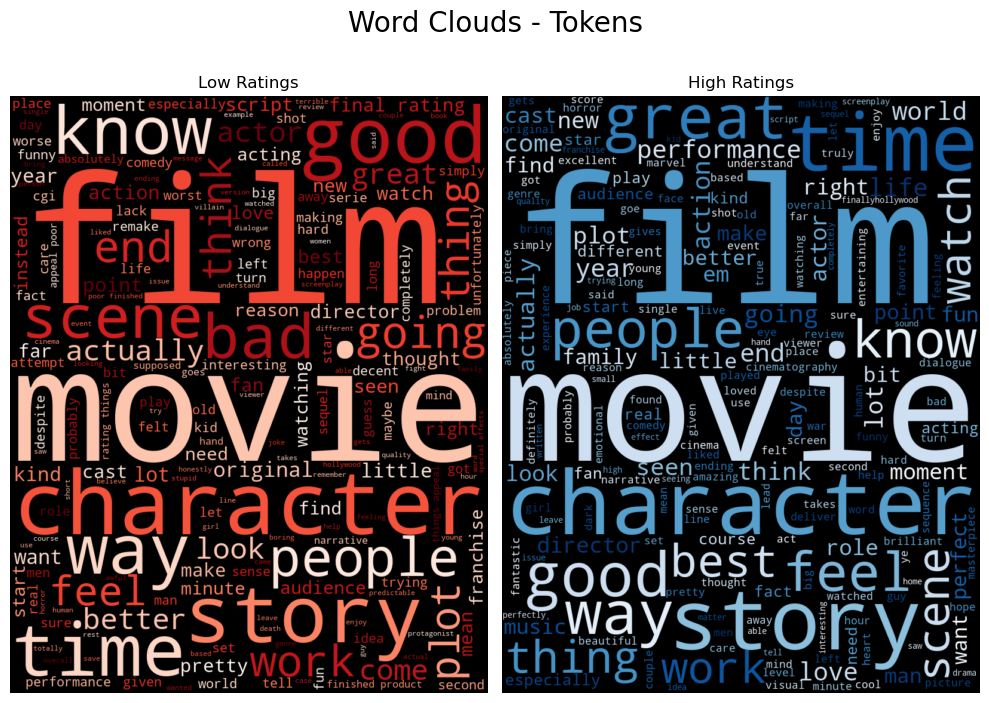

In [21]:
low_cloud = WordCloud(random_state = 42,
                     width = 800,
                     height = 1000,
                     min_word_length = 2, 
                     colormap = 'Reds').generate(low_reviews_tokens)

high_cloud = WordCloud(random_state=42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2,
                      colormap = 'Blues').generate(high_reviews_tokens)

fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Tokens', fontsize=20, y=1.05);

                                                   